In [53]:
# make sure the notebook reloads the module each time we modify it
%load_ext autoreload
%autoreload 2

# Uncomment the next line if you want to be able to zoom on plots
# %matplotlib notebook 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import parametric_regression_solution as pr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
import numpy as np
import pymc3 as pm
import warnings
warnings.filterwarnings('ignore')

## Preparing data and utilities

I've prepared a function to generate regression data
$$
y \sim \mathcal{N}(X\theta_{\text{true}}, \sigma^2 I). 
$$
Check how $\theta_{\text{true}}$ is generated, with a few ``support variables", and the rest of the coordinates close to zero.

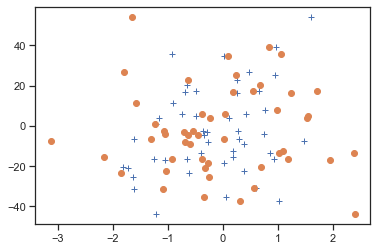

In [55]:
dimension = 100
sample_size = 50
X, y, theta_true, sigma_noise, indices_support = pr.generate_data(sample_size = sample_size, 
                                                        dimension = dimension, seed = 3)
plt.plot(X[:,indices_support[0]], y, '+')
plt.plot(X[:,0], y, 'o')
plt.show()

I've prepared a function to plot an estimator and the corresponding error bars, and compare it to the underlying true $\theta_{\text{true}}$ in green. The bottom plot is the same, but with $\theta_{\text{true}}$ substracted.

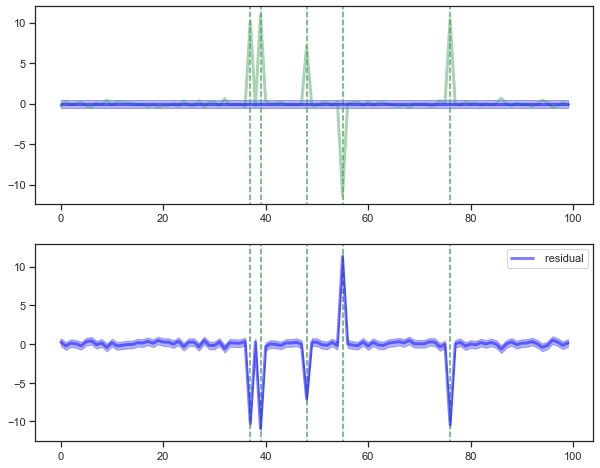

In [56]:
fake_std = .5*np.ones(theta_true.shape)
fake_theta_hat = np.zeros(theta_true.shape)
fig, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, color="blue", theta_true=theta_true, indices_support=indices_support, 
                     theta_hat=fake_theta_hat, lower_bound=fake_theta_hat-fake_std, 
                     upper_bound=fake_theta_hat+fake_std)
plt.show()

## Using sklearn's lasso implementation as baseline

Your first exercise is to get scikit-learn's lasso estimate as a baseline. Go to the companion Python file, and fill in the corresponding function. Then plot your estimate and comment.

In [57]:
theta_lasso = pr.get_sklearn_lasso_estimate(X, y)

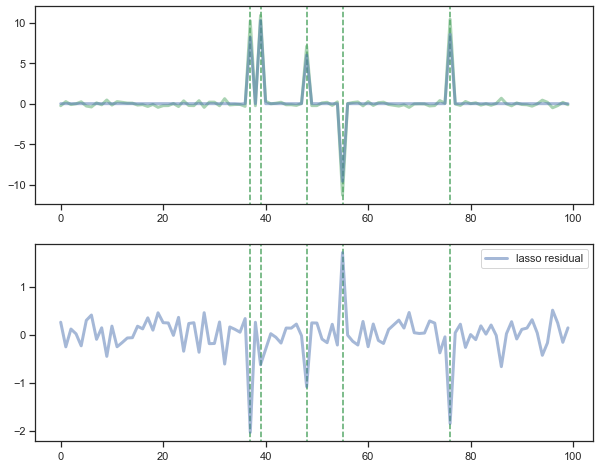

In [58]:
fig, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true=theta_true, indices_support=indices_support, theta_hat=theta_lasso, label="lasso")
plt.show()

<span style="color:red"> The estimated coefficients are sparse, as expected. Moreover, the  residuals $r_i$ are always of a sign different from the corresponding $\theta_i$, showing that the Lasso estimate is overregularized. This is the price of sparsity.</span>

## Bayesian lasso using a Laplace prior

You second exercise is to use `pymc3` to implement Bayesian linear regression with a Laplace prior. Again, fill in the corresponding function in the companion Python file. You should output a `pymc3` Trace object, with the $\theta$ variable of our regression problem named `theta`. Play around with different MCMC kernels.

*Hint*: Remember, the Laplace prior is the one that makes the MAP estimator be the solution to the frequentist Lasso.

In [59]:
trace = pr.get_mcmc_sample_for_laplace_prior(X, y)
accept = np.sum(trace['theta'][1:,0] != trace['theta'][:-1,0])
print("Acceptance Rate: ", accept/trace['theta'][:,0].shape[0])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:34<00:00, 294.05draws/s]


Acceptance Rate:  0.999875


<span style="color:red"> The acceptance rate is very high. Recommendations for HMC are usually high (say, above 50\%), but 99\% is suspicious: either it is easy for HMC to move along level lines of the target, or our chains failed to move efficiently across space and performed a lot of small jumps. Let us check the Gelman-Rubin diagnostic and plots some traces to visually assess whether this is the case.</span>

In [60]:
# Let's check a summary of that trace, find out what the columns mean in the doc
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,-0.451740,0.735034,0.008228,-1.995907,0.894659,9440.917454,0.999934
theta__1,0.066111,0.777848,0.007596,-1.553997,1.602610,9326.235076,0.999922
theta__2,0.183520,0.704153,0.007462,-1.224882,1.658091,9073.580978,0.999855
theta__3,-0.226313,0.881301,0.009149,-2.072774,1.495362,9486.277738,1.000068
theta__4,0.389183,0.774388,0.007377,-0.978200,2.083109,9119.628408,0.999896
theta__5,0.068311,0.768865,0.007795,-1.607399,1.588037,9778.451474,1.000003
theta__6,0.014955,0.703487,0.006524,-1.374694,1.512260,9384.117123,0.999818
theta__7,0.286823,0.731569,0.007083,-1.088446,1.833570,8864.835065,1.000224
theta__8,-0.044132,0.793912,0.007307,-1.699385,1.558584,10718.032398,1.000234
theta__9,0.369493,0.786038,0.007413,-1.147102,2.041324,9657.872626,1.000089


<span style="color:red"> $\hat R$ is very close to 1, a good sign.</span>

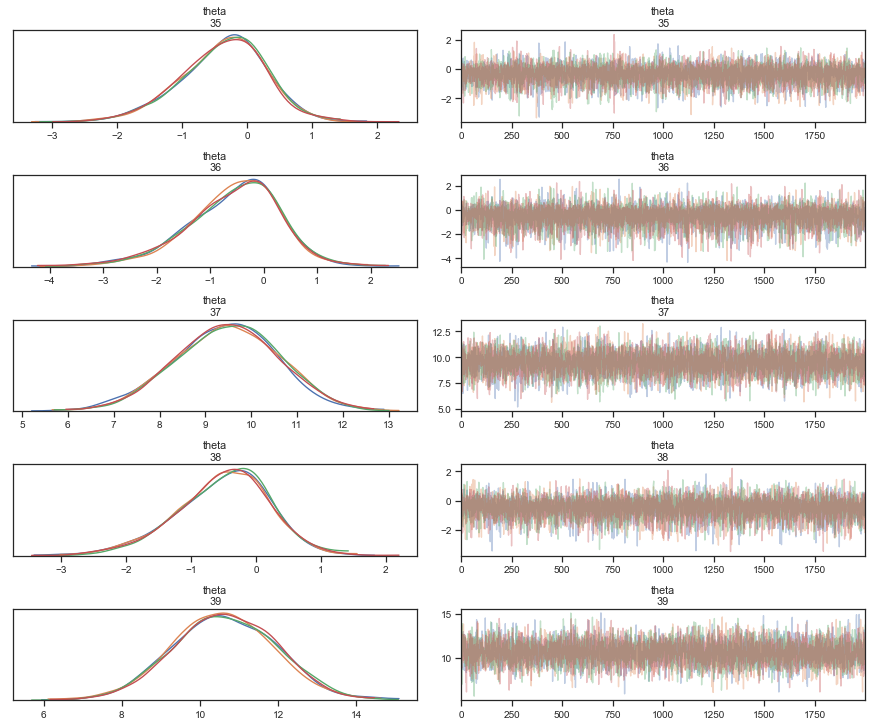

In [61]:
# Plot here a few trajectories of the chain corresponding to a variable in and out of support. 
pm.traceplot(trace, coords={'theta_dim_0':np.arange(35,40)}) #, compact=True)
plt.show()

  <span style="color:red"> The traces look very "i.i.d. like", and all chains led to the same marginal histograms. We thus consider that the chains have mixed well, in spite of the unusually high acceptance rate. We can now intepret the results. Note how the third and fifth components I've chosen to plot are being identified as nonzero. We can actually give credible intervals over these components, and we expect the third and fifth ones one to not include 0.</span>

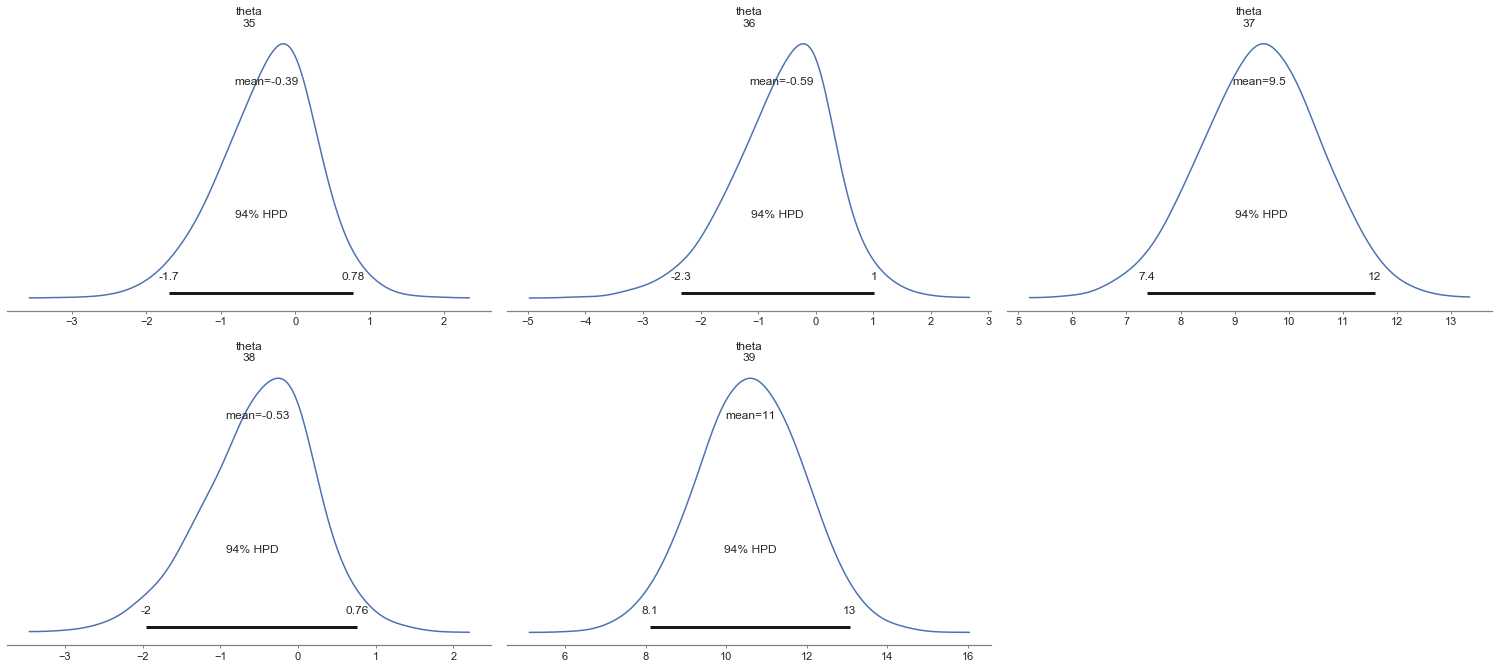

In [46]:
pm.plot_posterior(trace, coords={'theta_dim_0':np.arange(35,40)})
plt.show()

Your next exercise is to define the Bayesian estimator $\hat\theta_B$ for the squared loss, along with two vectors of length $d$ as well. They should contain the lower limit and the upper limit, respectively, of a 95% credible interval for each component of $\theta$. I've filled the arrays with zeros for now.

In [62]:
theta_laplace = trace.get_values('theta').mean(0) # not expected to show much sparsity
lower_bound_laplace = np.quantile(trace.get_values('theta'), 0.025, axis=0)
upper_bound_laplace = np.quantile(trace.get_values('theta'), 0.975, axis=0)

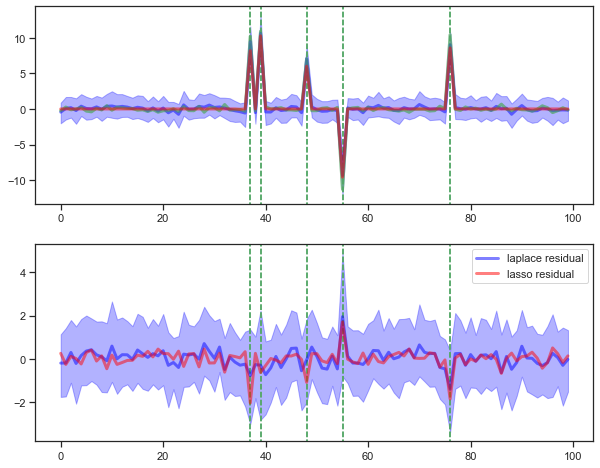

In [63]:
f, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_laplace, lower_bound=lower_bound_laplace, upper_bound=upper_bound_laplace,
             color="blue", label="laplace")
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_lasso, color="red", label="lasso")
plt.show()

The Laplace prior usually tends to overregularize. Can you get rid of that problem playing with the parameters of the prior?

<span style="color:red"> Not easily: this is the same problem that frequentists have with lasso. There is a conflict between taking a prior with a small support (i.e. a large penalty in the lasso) to induce sparsity, and a loose prior (to avoid overregularizing). To remove the overregularization, we need a prior that encodes a different regularization for "zero" components and components that are identified as signal. This is one of the motivations of the horseshoe prior.</span>

## Bayesian lasso using the horseshoe prior

We'll try to enforce some sparsity using a different prior, the ``horseshoe prior" of [Carvalho et al. '10](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&ved=2ahUKEwj11da8iZvnAhWJz4UKHZSXCccQFjABegQIBBAB&url=ftp%3A%2F%2Fwebster.stat.duke.edu%2Fpub%2FWorkingPapers%2F08-31.pdf&usg=AOvVaw09RPSqHPGq9kyfLBNsMJE2). Your next exercise is to repeat the steps of the Laplace prior for the horseshoe, and see what we gained/lost.

In [86]:
trace_horseshoe = pr.get_mcmc_sample_for_horseshoe_prior(X, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, lam, tau]
Sampling 4 chains: 100%|██████████| 42000/42000 [16:49<00:00, 41.61draws/s] 
There were 2230 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2770 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8142383219737575, but should be close to 0.9. Try to increase the number of tuning steps.
There were 2109 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1790 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, in

<span style="color:red"> We obtain warnings that NUTS had trouble tuning the parameters of the HMC step. The estimated ESS for some directions is very small, and pymc is recommending to reparametrize. One lazy solution is first to increase the number of MCMC steps: our chains has to converge, so in the limit, even if doesn't show good mixing, it should give the right answer. I have thus raised the number of iterations. Let us investigate the trace and try to see what happened. </span>

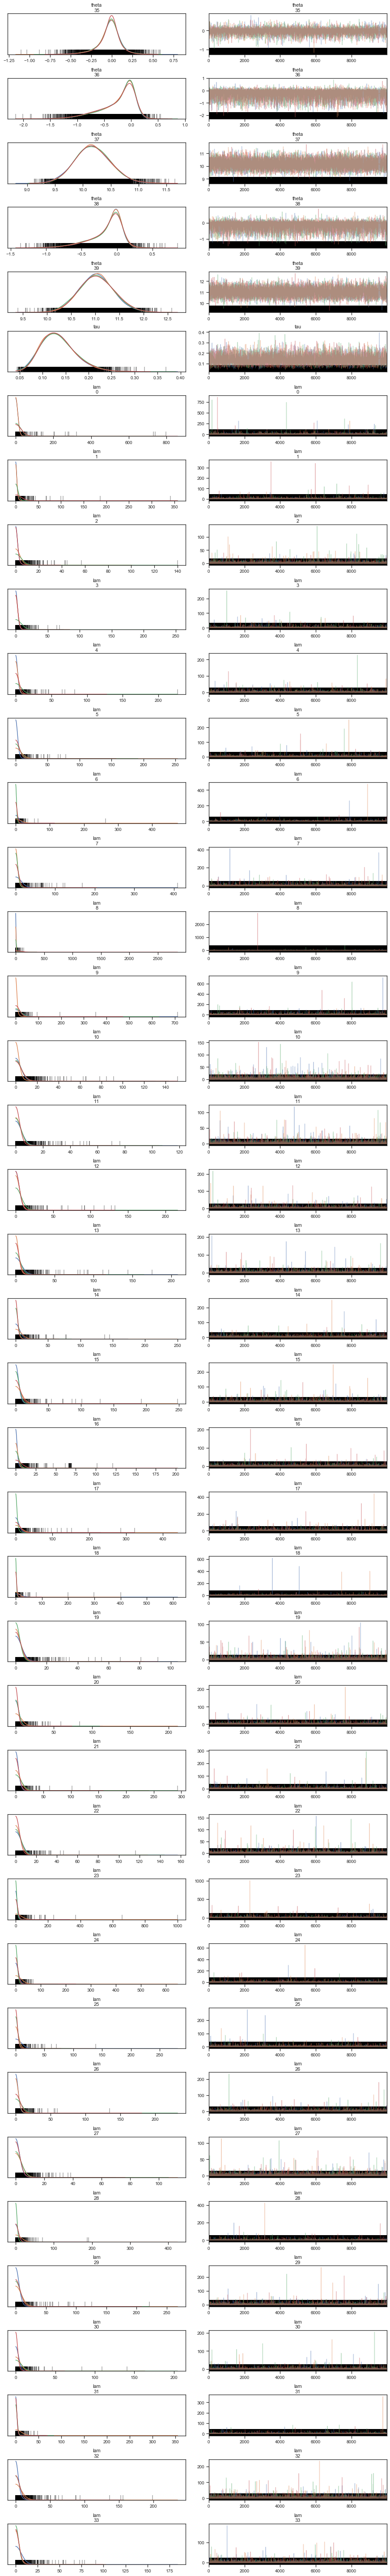

In [87]:
# Plot here a few trajectories of the chain corresponding to a variable in and out of support. 
pm.traceplot(trace_horseshoe, coords={'theta_dim_0':np.arange(35,40)}) #, compact=True)
plt.show()

<span style="color:red"> The theta chains and tau chains look like they reflect the same marginals, which is reassuring. This should show as a Gelman-Rubin diagnostic close to 1. The lambda chains look like they have a different spread, but the traces show that this is mostly due to a few outliers, due to the low penalization for trying large values of lambda once in a while. Running a much longer chain will remove the differences between the lambda marginals. Alternately, one could try to reparametrize the model to temper this fat tail behaviour of the half Cauchy; see [this post](https://mellorjc.github.io/HorseshoePriorswithpymc3.html). See also the Finnish horseshoe prior in the bonus questions below.
</span>

In [99]:
df = pm.summary(trace_horseshoe)
df.head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,-0.361730,0.300423,0.004802,-0.938688,0.089435,4487.526042,1.000008
theta__1,0.053104,0.175717,0.001924,-0.249132,0.504952,7420.275577,1.000190
theta__2,-0.005297,0.131855,0.001351,-0.301543,0.280193,8800.077625,1.000210
theta__3,-0.000379,0.168789,0.001933,-0.373593,0.371425,6567.424600,1.000425
theta__4,-0.004544,0.149973,0.001860,-0.312953,0.348417,5822.022254,1.000313


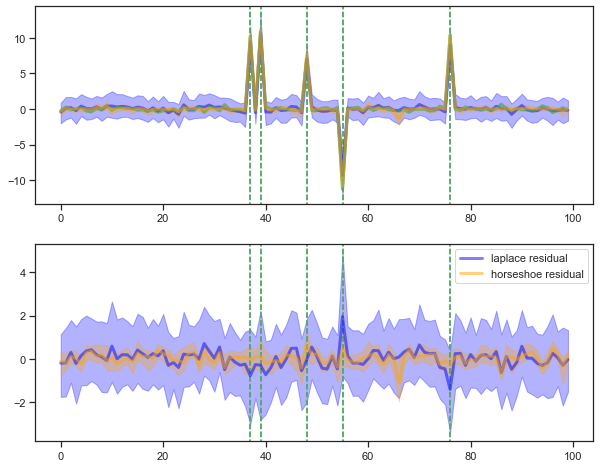

In [100]:
# Again, fill in the Bayesian estimator for the squared loss and credible intervals.
theta_horseshoe = trace_horseshoe.get_values('theta').mean(0)
lower_bound_horseshoe = np.quantile(trace_horseshoe.get_values('theta'), 0.025, axis=0)
upper_bound_horseshoe = np.quantile(trace_horseshoe.get_values('theta'), 0.975, axis=0)

# This will plot your estimates so far for comparison
f, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_laplace, lower_bound=lower_bound_laplace, upper_bound=upper_bound_laplace,
                     color="blue", label="laplace")
pr.plot_coefficients(ax, theta_true=theta_true, indices_support=indices_support, theta_hat=theta_horseshoe, lower_bound=lower_bound_horseshoe, 
                     upper_bound=upper_bound_horseshoe, color="orange", label="horseshoe")
#pr.plot_coefficients(theta_true, theta_lasso, color="red", label="lasso")

plt.show()

<span style="color:red"> 
The horsehoe prior has smaller residuals and does not seem to overregularize the nonzero coefficients. Mission accomplished!
</span>

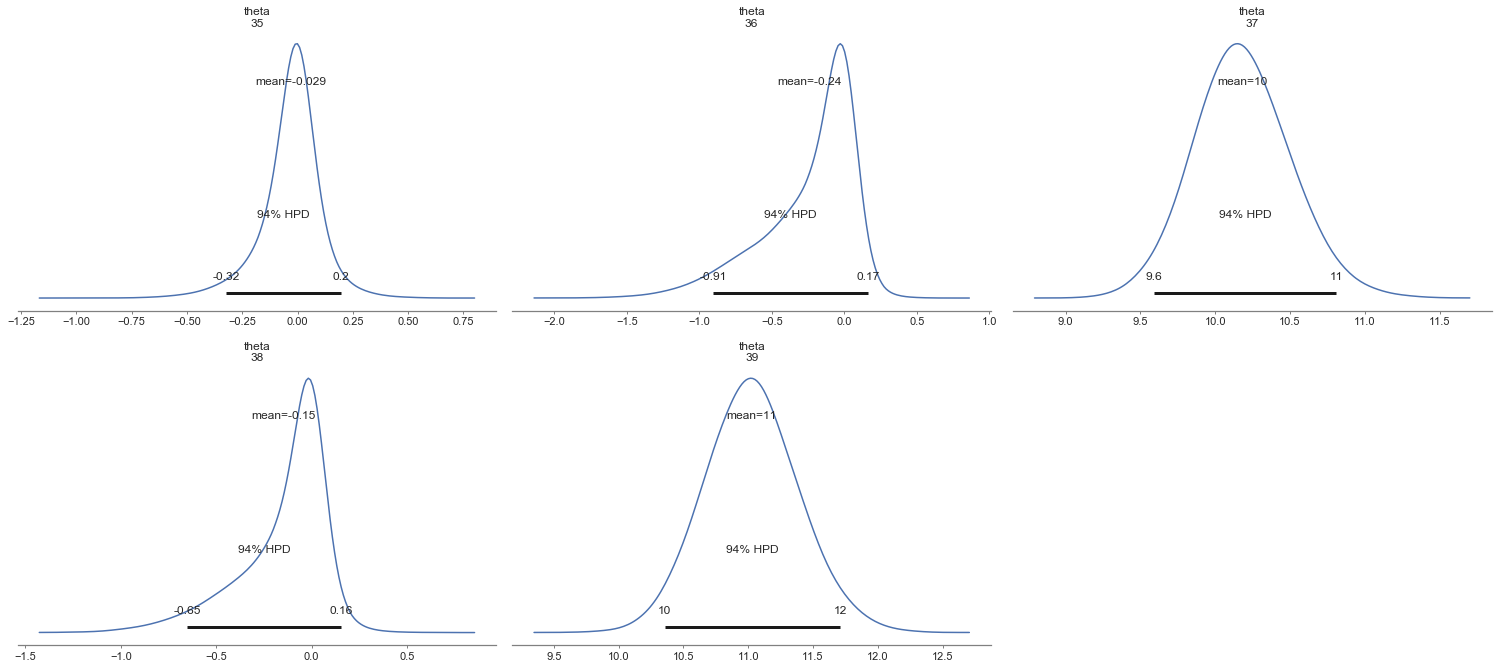

In [102]:
# Let us check a few credible intervals output by pymc as well
pm.plot_posterior(trace_horseshoe, var_names='theta', coords={'theta_dim_0':np.arange(35,40)})
plt.show()

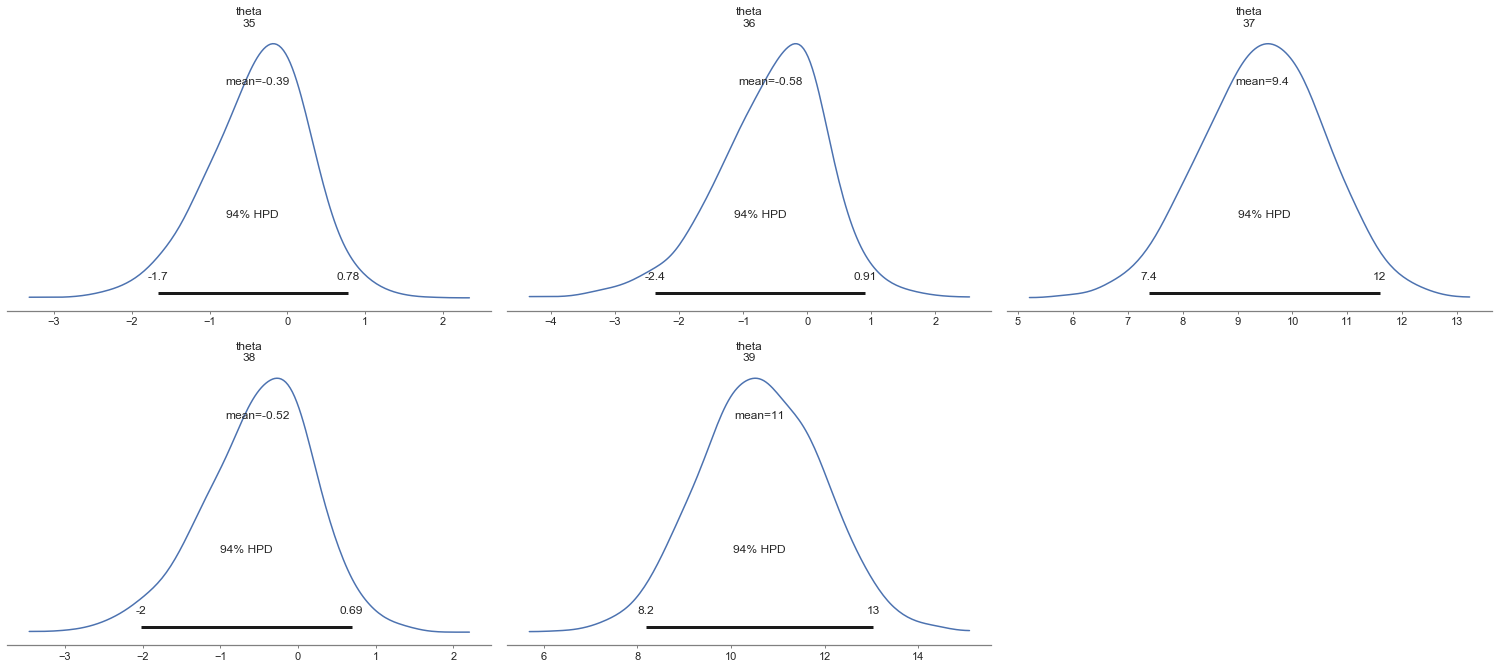

In [103]:
# Compare them to the ones obtained for Laplace
pm.plot_posterior(trace, coords={'theta_dim_0':np.arange(35,40)})
plt.show()

## Bayesian lasso using the Finnish horseshoe prior

If you've made it so far, you've deserved to pick your last exercise: either 
* find a dataset of your liking to which you apply the previous estimators. 
* delve into more subtle priors, with, e.g. the Finnish horseshoe prior of [Piironen and Vehtari '17](https://arxiv.org/pdf/1707.01694.pdf). You can use the cells below.
* Try to learn more about HMC and its NUTS variant, the flagship MCMC kernel of `pymc3`. How are the HMC parameters tuned in NUTS? Can you prove that the resulting Markov kernel leaves the target distribution invariant?

In [ ]:
trace_finnish_horseshoe = pr.get_mcmc_sample_for_finnish_horseshoe_prior(X, y)

In [ ]:
theta_finnish_horseshoe = np.zeros((dimension,))
lower_bound_finnish_horseshoe = np.zeros((dimension,))
upper_bound_finnish_horseshoe = np.zeros((dimension,))

In [ ]:
f, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_laplace,
                     color="blue", label="laplace")
pr.plot_coefficients(ax, theta_true=theta_true, indices_support=indices_support, theta_hat=theta_horseshoe, lower_bound=lower_bound_horseshoe, 
                     upper_bound=upper_bound_horseshoe, color="orange", label="horseshoe")
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_finnish_horseshoe, lower_bound=lower_bound_finnish_horseshoe, 
                     upper_bound=upper_bound_finnish_horseshoe, color="magenta", label="finnish")
#pr.plot_coefficients(theta_true, theta_lasso, color="red", label="lasso")

plt.show()